#Installations & Imports

In [28]:
!pip install pytorch-lightning

In [29]:
import torch
import torchvision
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#Parameter Initialization

In [30]:
import os
# Insert your own path here
ds_path = os.path.join(".", "drive", "My Drive", "Machine Learning", "Datasets")

variation = "VAE"

configuration = {
    "dataset": "MNIST",
    "path": ds_path
}

architecture = {
    "conv_layers": 3,
    "conv_channels": [16, 32, 64],
    "conv_kernel_sizes": [(7, 7), (7, 7), (7, 7)],
    "conv_strides": [(1, 1), (1, 1), (1, 1)],
    "conv_paddings": [(1, 1), (1, 1), (1, 1)],
    "z_dimension": 64
}

hyperparameters = {
    "epochs": 50,
    "batch_size": 16,
    "learning_rate": 3e-7
}

In [31]:
def prepare_dataset(configuration):
    """
    :param dict configuration: The configuration dictionary returned by parse_config_file

    :return:        A dictionary containing information about the dataset used

    Function used to set some values used by the model based on the dataset selected
    """
    dataset_info = {}
    if (configuration["dataset"] == "MNIST"):
        dataset_info["ds_method"] = torchvision.datasets.MNIST
        dataset_info["ds_shape"] = (1, 28, 28)
        dataset_info["ds_path"] = configuration["path"]
    elif (configuration["dataset"] == "CIFAR10"):
        dataset_info["ds_method"] = torchvision.datasets.CIFAR10
        dataset_info["ds_shape"] = (3, 32, 32)
        dataset_info["ds_path"] = configuration["path"]
    else:
        print("Currently only MNIST & CIFAR10 datasets are supported")
        return None

    return dataset_info

In [32]:
dataset_info = prepare_dataset(configuration)

#Model Declaration

#####Utility Functions

In [33]:
from torch import nn
def compute_output_shape(current_shape, kernel_size, stride, padding):
    """
    :param tuple current_shape:  The current shape of the data before a convolution is applied.
    :param tuple kernel_size:    The kernel size of the current convolution operation.
    :param tuple stride:         The stride of the current convolution operation.
    :param tuple padding:        The padding of the current convolution operation.

    :return:         The shape after a convolution operation with the above parameters is applied
                     (as a tuple).
                     The formula used to compute the final shape is

        component[i] = floor((W[i] - K[i] + 2 * P[i]) / S[i]) + 1

        where, W = input shape of the data
               K = kernel size
               P = padding
               S = stride
    """
    # get the dimension of the data
    dimensions = len(current_shape)
    # compute each component using the above formula and return
    return tuple((current_shape[i] - kernel_size[i] + 2 * padding[i]) // stride[i] + 1
                 for i in range(dimensions))


def invalid_shape(current_shape):
    """
    :param tuple current_shape: The current shape of the data after a convolution is applied.

    :return:        True if the shape is invalid, that is, a negative or 0 components exists. Else,
                    it returns False.
    """
    # check all components
    for component in current_shape:
        if component <= 0:
            return True
    # return False if they are ok
    return False


def create_encoder(architecture, input_shape):
    """
    :param dict architecture:  A dictionary containing the hyperparameters that define the
                               architecture of the model.
    :param tuple input_shape:  A tuple that corresponds to the shape of the input.

    :return:             A PyTorch Sequential model that represents the encoder part of a VAE.

    This method builds the encoder part of a VAE and returns it. It is common for all types of VAE.
    """

    # the number of channels that the input image has
    in_channels = input_shape[0]

    # keep track of the current Height and Width of the image
    current_shape = (input_shape[1], input_shape[2])

    # build the encoder part
    sets_of_conv_selu_bn = []

    # iterate through the lists that define the architecture of the encoder
    for layer in range(architecture["conv_layers"]):

        # define the number of output channels (filters) for this layer
        out_channels = architecture["conv_channels"][layer]

        # add a set of Convolutional - SeLU - Batch Normalization sequential layers
        conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                         kernel_size=architecture["conv_kernel_sizes"][layer],
                         stride=architecture["conv_strides"][layer],
                         padding=architecture["conv_paddings"][layer])
        selu = nn.LeakyReLU()
        batch_norm = nn.BatchNorm2d(out_channels)

        # define a sequential model with the above architecture append it to the list
        sets_of_conv_selu_bn.append(nn.Sequential(conv, selu, batch_norm))

        # compute the new shape of the image
        current_shape = compute_output_shape(current_shape,
                                             architecture["conv_kernel_sizes"][layer],
                                             stride=architecture["conv_strides"][layer],
                                             padding=architecture["conv_paddings"][layer])

        # make sure that the shape is valid, and if not, raise an error
        if invalid_shape(current_shape):
            print("Architecture is invalid, please modify it")
            return None


        # the output channels of the current layer becomes the input channels of the next layer
        in_channels = out_channels

    # create a Sequential model and return it (* asterisk is used to unpack the list)
    return nn.Sequential(*sets_of_conv_selu_bn), current_shape


def create_decoder(architecture):
    """
    :param dict architecture:  A dictionary containing the hyperparameters that define the
                               architecture of the model.

    :return:            A PyTorch Sequential model that represents the decoder part of a VAE.

    This method builds the decoder part of a VAE and returns it. It is common for all types of VAE.
    """
    # now start building the decoder part
    sets_of_convtr_selu_bn = []

    # define the current number of channels (after the reformation of the latent vector z)
    in_channels = architecture["conv_channels"][-1]

    # iterate through the lists that define the architecture of the decoder
    for layer in range(architecture["conv_layers"] - 1, -1, -1):

        # define the number of output channels (filters) for this layer
        out_channels = architecture["conv_channels"][layer]

        # add a set of ConvolutionalTranspose - SeLU - Batch Normalization sequential layers
        convtr = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=architecture["conv_kernel_sizes"][layer],
                                    stride=architecture["conv_strides"][layer],
                                    padding=architecture["conv_paddings"][layer])
        selu = nn.LeakyReLU()
        batch_norm = nn.BatchNorm2d(out_channels)

        # define a sequential model with this architecture append it to the list
        sets_of_convtr_selu_bn.append(nn.Sequential(convtr, selu, batch_norm))

        # the output channels of the current layer becomes the input channels of the next layer
        in_channels = out_channels

    # create a Sequential model and return it (* asterisk is used to unpack the list)
    return nn.Sequential(*sets_of_convtr_selu_bn)


def create_output_layer(architecture, input_shape):
    """
    :param dict architecture:  A dictionary containing the hyperparameters that define the
                               architecture of the model.
    :param tuple input_shape:  A tuple that corresponds to the shape of the input.

    :return:             A PyTorch Sequential model that represents the output layer of a VAE.

    This method creates the output layer of a VAE, that is, the layer where the data from the
    output of the decoder gets fed in order to be finally reconstructed.
    """

    # define the number of input channels of the last layer
    in_channels = architecture["conv_channels"][0]

    # define the output layer: ConvTranspose2d -> SELU -> Batch Norm -> Conv2d -> Sigmoid
    convtr = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels,
                                kernel_size=architecture["conv_kernel_sizes"][0],
                                stride=architecture["conv_strides"][0],
                                padding=architecture["conv_paddings"][0])
    selu = nn.LeakyReLU()
    batch_norm = nn.BatchNorm2d(in_channels)
    conv = nn.Conv2d(in_channels=in_channels, out_channels=input_shape[0],
                     kernel_size=architecture["conv_kernel_sizes"][0],
                     stride=architecture["conv_strides"][0],
                     padding=architecture["conv_paddings"][0])
    sigmoid = nn.Sigmoid()

    # create a Sequential model and return it
    return nn.Sequential(convtr, selu, batch_norm, conv, sigmoid)

###Variational Auto-Encoder

In [34]:
import multiprocessing

class VAE(pl.LightningModule):
    """ Class that implements a Variational Autoencoder """

    def __init__(self, architecture, hyperparameters, dataset_info):
        """
        :param dict architecture:      A dictionary containing the hyperparameters that define the
                                       architecture of the model.
        :param dict hyperparameters:   A tuple that corresponds to the shape of the input.
        :param dict dataset_info:      The dimension of the latent vector z (bottleneck).

        :return:                       An instance of the VAE class

        The constructor of the Variational Autoencoder.
        """

        # call the constructor of the super class
        super(VAE, self).__init__()

        # initialize class variables regarding the architecture of the model
        self.conv_layers = architecture["conv_layers"]
        self.conv_channels = architecture["conv_channels"]
        self.conv_kernel_sizes = architecture["conv_kernel_sizes"]
        self.conv_strides = architecture["conv_strides"]
        self.conv_paddings = architecture["conv_paddings"]
        self.z_dim = architecture["z_dimension"]

        # unpack the "hyperparameters" dictionary
        self.batch_size = hyperparameters["batch_size"]
        self.learning_rate = hyperparameters["learning_rate"]
        self.scheduler_step_size = hyperparameters["epochs"]//2

        # unpack the "dataset_info" dictionary
        self.dataset_method = dataset_info["ds_method"]
        self.dataset_shape = dataset_info["ds_shape"]
        self.dataset_path = dataset_info["ds_path"]

        # build the encoder
        self.encoder, self.encoder_output_shape = create_encoder(architecture, self.dataset_shape)

        # compute the length of the output of the decoder once it has been flattened
        in_features = self.conv_channels[-1] * np.prod(self.encoder_output_shape[:])
        # now define the mean and standard deviation layers
        self.mean_layer = nn.Linear(in_features=in_features, out_features=self.z_dim)
        self.std_layer = nn.Linear(in_features=in_features, out_features=self.z_dim)

        # use a linear layer for the input of the decoder
        in_channels = self.conv_channels[-1]
        self.decoder_input = nn.Linear(in_features=self.z_dim, out_features=in_features)

        # build the decoder
        self.decoder = create_decoder(architecture)

        # build the output layer
        self.output_layer = create_output_layer(architecture, self.dataset_shape)

    def _encode(self, X):
        """
        :param Tensor X:  Input to encode into mean and standard deviation.
                          (N, input_shape[1], H, W)

        :return:          A tuple with the mean and std tensors that the encoder produces
                          for input X. (N, z_dim)

        This method applies forward propagation to the self.encoder in order to get the mean and
        standard deviation of the latent vector z.
        """
        # run the input through the encoder part of the Network
        encoded_input = self.encoder(X)

        # flatten so that it can be fed to the mean and standard deviation layers
        encoded_input = torch.flatten(encoded_input, start_dim=1)

        # compute the mean and standard deviation
        mean = self.mean_layer(encoded_input)
        std = self.std_layer(encoded_input)

        return mean, std

    def _compute_latent_vector(self, mean, std):
        """
        :param Tensor mean:  The mean of the latent vector z following a Gaussian distribution.
                             (N, z_dim)
        :param Tensor std:   The standard deviation of the latent vector z following a Gaussian
                             distribution. (N, z_dim)

        :return:             A Tensor of the Linear combination of the mean and standard deviation, where the latter
                             factor is multiplied with a random variable epsilon ~ N(0, 1). Basically
                             the latent vector z. (N, z_dim)

        This method computes the latent vector z by applying the reparameterization trick to the
        output of the mean and standard deviation layers, in order to be able to later compute the
        gradient. The stochasticiy here is introduced by the factor epsilon, which is an independent
        node. Thus, we do not have to compute its gradient during backpropagation.
        """

        # compute the stochastic node epsilon
        epsilon = torch.randn_like(std)
        # raise the standard deviation to an exponent, to improve numberical stability
        std = torch.exp(1/2 * std)

        # compute the linear combination of the above attributes and return
        return mean + epsilon * std

    def _decode(self, z):
        """
        :param Tensor z:   Latent vector computed using the mean and variance layers (with the
                           reparameterization trick). (N, z_dim)

        :return:           A Tensor with The output of the decoder part of the network.
                           (N, input_shape[1], H, W)

        This method performs forward propagation of the latent vector through the decoder of the
        VAE to get the final output of the network.
        """
        # run the latent vector through the "input decoder" layer
        decoder_input = self.decoder_input(z)

        # convert back the shape that will be fed to the decoder
        height = self.encoder_output_shape[0]
        width = self.encoder_output_shape[1]
        decoder_input = decoder_input.view(-1, self.conv_channels[-1], height, width)

        # run through the decoder
        decoder_output = self.decoder(decoder_input)

        # run through the output layer and return
        network_output = self.output_layer(decoder_output)
        return network_output

    def forward(self, X):
        """
        :param Tensor X: The input to run through the VAE. (N, input_shape[1], H, W)

        :return:         A tuple consisting of the output of the Network,
                         and the mean-standard deviation layers.
                         (N, input_shape[1], H, W), (N, z_dim), (N, z_dim)

        This method performs Forward Propagation through all the layers of the VAE and returns
        the reconstructed input.
        """
        # encode the input to get mean and standard deviation
        mean, std = self._encode(X)

        # get the latent vector z by using the reparameterization trick
        z = self._compute_latent_vector(mean, std)

        # compute the output by propagating the latent vector through the decoder and return
        decoded_output = self._decode(z)
        return decoded_output, mean, std

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.scheduler_step_size, gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        """
        :param Tensor batch:  The current batch of the training set
        :param int batch_idx: The batch index of the current batch

        :return:              A dictionary of the losses computed on the current prediction
        """
        # unpack the current batch
        X, y = batch

        # pass it through the model
        X_hat, mean, std = self(X)
        # calculate the losses
        losses = self.criterion(X, X_hat, mean, std)

        return losses

    def train_dataloader(self):
        """
        :return:    A DataLoader object of the training set
        """
        # download the training set using torchvision
        # if the set already exists in the provided path, it is not downloaded
        train_set = self.dataset_method(root=self.dataset_path, train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
        # initialize a pytorch DataLoader to feed training batches into the model
        self.train_loader = DataLoader(dataset=train_set, batch_size=self.batch_size, shuffle=True, num_workers=multiprocessing.cpu_count()//2)
        return self.train_loader

    def test_step(self, batch, batch_idx):
        """
        :param Tensor batch:  The current batch of the test set
        :param int batch_idx: The batch index of the current batch

        :return:              A tuple consisting of a dictionary of the losses
                              computed on the current prediction and the MSE Loss
                              compared to the original picture
        """
        # unpack the current batch
        X, y = batch

        # pass it through the model
        X_hat, mean, std = self(X)
        # calculate the losses
        losses = self.criterion(X, X_hat, mean, std)

        # also calculate the MSE loss
        mse_loss_func = torch.nn.MSELoss()
        mse_loss = mse_loss_func(X, X_hat)

        self.log('mse_loss', mse_loss.item())
        self.log('losses', losses)
        return losses, mse_loss

    def test_dataloader(self):
        """
        :return:    A DataLoader object of the test set
        """
        # download the test set using torchvision
        # if the set already exists in the provided path, it is not downloaded
        test_set = self.dataset_method(root=self.dataset_path, train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
        # initialize a pytorch DataLoader to feed test batches into the model
        self.test_loader = DataLoader(dataset=test_set, batch_size=self.batch_size, shuffle=True, num_workers=multiprocessing.cpu_count()//2)
        return self.test_loader

    def sample(self, number_of_images):
        """
        :param int number_of_images: The amount of images to compare against each other

        :return:                     Does not return anything

        This method plots n generated images next to each other
        """

        # get as many batches from the test set to fill the final plot
        tensors = []
        img_count = 0
        while number_of_images*number_of_images > img_count:
            batch, y = next(iter(self.test_loader))
            img_count += len(batch)
            tensors.append(batch)

        # concatenate them
        X = torch.cat(tensors, dim=0)

        # pass them through the model
        X_hat, mean, std = self(X)

        min_imgs = min(number_of_images, len(X))

        # set the correct colourmap that corresponds to the image dimension
        cmap = None
        if (self.dataset_shape[0] == 3):
            cmap = 'viridis'
        elif (self.dataset_shape[0] == 1):
            cmap = 'gray'

        plot_multiple(X_hat.detach().numpy(), min_imgs, self.dataset_shape, cmap)

    @staticmethod
    def _data_fidelity_loss(X, X_hat, eps=1e-10):
        """
        :param Tensor X:      The original input data that was passed to the VAE.
                               (N, input_shape[1], H, W)
        :param Tensor X_hat:  The reconstructed data, the output of the VAE.
                               (N, input_shape[1], H, W)
        :param Double eps:    A small positive double used to ensure we don't get log of 0.

        :return:              A tensor containing the Data Fidelity term of the loss function,
                              which is given by the formula

        E_{z ~ Q_{phi}(z | x)}[log(P_{theta}(x|z))] = sum(x * log(x_hat) + (1 - x) * log(1 - x_hat))

            which is basically a Cross Entropy Loss.

        This method computes the Data Fidelity term of the loss function. A small positive double
        epsilon is added inside the logarithm to make sure that we don't get log(0).
        """
        # compute the data fidelity for every training example
        data_fidelity = torch.sum(X * torch.log(eps + X_hat) + (1 - X) * torch.log(eps + 1 - X_hat),
                                  axis=[1, 2, 3])
        return data_fidelity

    @staticmethod
    def _kl_divergence_loss(mean, std):
        """
        :param Tensor mean:   The output of the mean layer, computed with the output of the
                               encoder. (N, z_dim)
        :param Tensor std:    The output of the standard deviation layer, computed with the output
                               of the encoder. (N, z_dim)

        :return:              A tensor consisting of the KL-Divergence term of the loss function,
                              which is given by the formula

        D_{KL}[Q_{phi}(z | x) || P_{theta}(x)] = (1/2) * sum(std + mean^2 - 1 - log(std))

            In the above equation we substitute std with e^{std} to improve numerical stability.

        This method computes the KL-Divergence term of the loss function. It substitutes the
        value of the standard deviation layer with exp(standard deviation) in order to ensure
        numerical stability.
        """
        # compute the kl divergence for each training example and return it
        kl_divergence = (1 / 2) * torch.sum(torch.exp(std) + torch.square(mean) - 1 - std, axis=1)
        return kl_divergence

    def criterion(self, X, X_hat, mean, std):
        """
        :param Tensor X:      The original input data that was passed to the VAE.
                               (N, input_shape[1], H, W)
        :param Tensor X_hat:  The reconstructed data, the output of the VAE.
                               (N, input_shape[1], H, W)
        :param Tensor mean:   The output of the mean layer, computed with the output of the
                               encoder. (N, z_dim)
        :param Tensor std:    The output of the standard deviation layer, computed with the output
                               of the encoder. (N, z_dim)

        :return:              A dictionary containing the values of the losses computed.

        This method computes the loss of the VAE using the formula:

            L(x, x_hat) = - E_{z ~ Q_{phi}(z | x)}[log(P_{theta}(x|z))]
                          + D_{KL}[Q_{phi}(z | x) || P_{theta}(x)]

        Intuitively, the expectation term is the Data Fidelity term, and the second term is a
        regularizer that makes sure the distribution of the encoder and the decoder stay close.
        """
        # get the 2 losses
        data_fidelity_loss = VAE._data_fidelity_loss(X, X_hat)
        kl_divergence_loss = VAE._kl_divergence_loss(mean, std)

        # add them, and then compute the mean over all training examples
        loss = -data_fidelity_loss + kl_divergence_loss
        loss = torch.mean(loss)

        # place them all inside a dictionary and return it
        losses = {"data_fidelity": torch.mean(data_fidelity_loss),
                  "kl-divergence": torch.mean(kl_divergence_loss),
                  "loss": loss}
        return losses

###B-VAE

In [35]:
class betaVAE(VAE):
    """
    Class that implements a Disentangled Variational Autoencoder (Beta VAE).
    This class inherits from the VAE class.
    """

    def __init__(self, architecture, hyperparameters, dataset_info):
        """
        :param dict architecture:      A dictionary containing the hyperparameters that define the
                                       architecture of the model.
        :param dict hyperparameters:   A tuple that corresponds to the shape of the input.
        :param dict dataset_info:      The dimension of the latent vector z (bottleneck).

        :return:                       An instance of the VAE class

        The constructor of the Disentangled Variational Autoencoder.
        """

        # invoke the constructor of the VAE class, as the architecture is the same
        super(betaVAE, self).__init__(architecture, hyperparameters, dataset_info)

        # store the value of beta in the class as it exists only in this VAE variation
        self.beta = hyperparameters["beta"]


    def criterion(self, X, X_hat, mean, std):
        """
        :param Tensor X:      The original input data that was passed to the B-VAE.
                               (N, input_shape[1], H, W)
        :param Tensor X_hat:  The reconstructed data, the output of the B-VAE.
                               (N, input_shape[1], H, W)
        :param Tensor mean:   The output of the mean layer, computed with the output of the
                               encoder. (N, z_dim)
        :param Tensor std:    The output of the standard deviation layer, computed with the output
                               of the encoder. (N, z_dim)

        :return:              A dictionary containing the values of the losses computed.

        This method computes the loss of the B-VAE using the formula:

            L(x, x_hat) = - E_{z ~ Q_{phi}(z | x)}[log(P_{theta}(x|z))]
                          + beta * D_{KL}[Q_{phi}(z | x) || P_{theta}(x)]

        Intuitively, the expectation term is the Data Fidelity term, and the second term is a
        regularizer that makes sure the distribution of the encoder and the decoder stay close.
        """
        # get the 2 losses
        data_fidelity_loss = VAE._data_fidelity_loss(X, X_hat)
        kl_divergence_loss = VAE._kl_divergence_loss(mean, std)

        # add them, and then compute the mean over all training examples
        loss = -data_fidelity_loss + self.beta * kl_divergence_loss
        loss = torch.mean(loss)

        # place them all inside a dictionary and return it
        losses = {"data_fidelity": torch.mean(data_fidelity_loss),
                  "kl-divergence": torch.mean(kl_divergence_loss),
                  "beta_kl-divergence": torch.mean(self.beta * kl_divergence_loss),
                  "loss": loss}
        return losses

#Model Training

###Trainer Initialization

In [36]:
from pytorch_lightning import Trainer

model = None
if (variation == "VAE"):
  model = VAE(architecture, hyperparameters, dataset_info)
elif (variation == "B-VAE"):
  model = betaVae(architecture, hyperparameters, dataset_info)

trainer = Trainer(max_epochs = hyperparameters["epochs"], gpus=1, fast_dev_run=False, progress_bar_refresh_rate=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch


###Model fitting (training)

In [37]:
trainer.fit(model)


  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 126 K 
1 | mean_layer    | Linear     | 1.0 M 
2 | std_layer     | Linear     | 1.0 M 
3 | decoder_input | Linear     | 1.1 M 
4 | decoder       | Sequential | 326 K 
5 | output_layer  | Sequential | 13.4 K


1

#Model testing

###Testing on the test set

In [38]:
result = trainer.test(model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'losses': {'data_fidelity': tensor(-548.4006, device='cuda:0'),
            'kl-divergence': tensor(0.0117, device='cuda:0'),
            'loss': tensor(548.4124, device='cuda:0')},
 'mse_loss': tensor(0.2350)}
--------------------------------------------------------------------------------



###Utility function to plot two images against each other

In [39]:
def plot_multiple(images, n, dim, cmap):
    """
    :param arr images:          An array of images stored as a numpy array
    :param int n:               The width and height of the plot in terms of images
    :param tuple dim:           The dimension of the images
    :param str cmap:            The colourmap to be used by pyplot

    :return:                    Nothing

    Function used to plot multiple images in one single plot
    """
    # unpack the image dimensions
    z_dim, x_dim, y_dim = dim

    # if image is grayscale
    if (z_dim == 1):
        # initialize some limits on x&y
        x_limit = np.linspace(-2, 2, n)
        y_limit = np.linspace(-2, 2, n)

        # initialize the final combined image
        empty = np.empty((x_dim*n, y_dim*n))

        current = 0
        for i, zi in enumerate(x_limit):
            for j, pi in enumerate(y_limit):
                # each image insert it into a subsection of the final image
                empty[(n-i-1)*x_dim:(n-i)*x_dim, j*y_dim:(j+1)*y_dim] = images[current][0]
                current+=1

        plt.figure(figsize=(8, 10))

        x,y = np.meshgrid(x_limit, y_limit)
        plt.imshow(empty, origin="upper", cmap=cmap)
        plt.grid(False)
        plt.show()

    # if the image is rgb
    elif (z_dim == 3):
        # initialize some limits on x&y
        x_limit = np.linspace(-2, 2, n)
        y_limit = np.linspace(-2, 2, n)

        # initialize the final combined image (now with one more dim)
        empty = np.empty((x_dim*n, y_dim*n, 3))

        current = 0
        for i, zi in enumerate(x_limit):
            for j, pi in enumerate(y_limit):
                # flatten the image
                curr_img = images[current].ravel()
                # reshape it into the correct shape for pyplot
                curr_img = np.reshape(curr_img, (x_dim, y_dim, z_dim), order='F')
                # rotate it by 270 degrees
                curr_img = np.rot90(curr_img, 3)

                # insert it into a subsection of the final image
                empty[(n-i-1)*x_dim:(n-i)*x_dim, j*y_dim:(j+1)*y_dim] = curr_img
                current+=1

        plt.figure(figsize=(8, 10))

        x,y = np.meshgrid(x_limit, y_limit)
        plt.imshow(empty, origin="upper", cmap=cmap)
        plt.grid(False)
        plt.show()

###Small sample of the model to evaluate the training

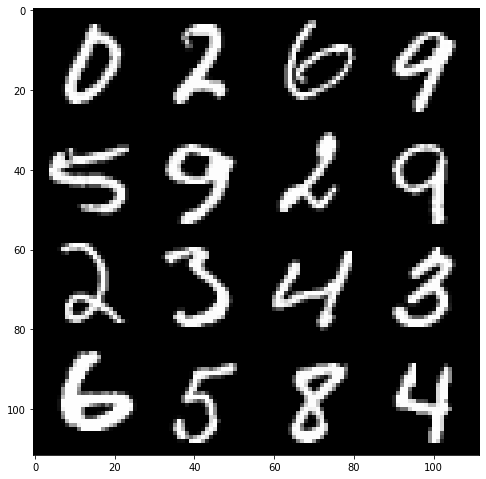

In [40]:
model = model.cpu()
model.sample(6)